In [1]:
import os
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import decomposition, cluster

from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import polyglot
from polyglot.text import Text, Word
import random


print(__doc__)
# 
# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
# X, y = make_blobs(n_samples=500,
#                  n_features=2,
#                  centers=4,
#                  cluster_std=1,
#                  center_box=(-10.0, 10.0),
#                  shuffle=True,
#                  random_state=1)  # For reproducibility

__file__ = os.getcwd()
dirname = os.path.dirname(__file__)
input_file = os.path.join(dirname, 'scripts\\data\\dogodki100inglavnekategorije_strippedOnlySlov.csv')
#input_file = os.path.join(dirname, 'scripts\\data\\dogodki50_spucano_glavnekategorije_veselice.csv')
df = pd.read_csv(input_file, header = 0)
original_headers = list(df.columns.values)
data_opis_normalized = df['opis'].astype('U')
data_kats = df['kategorije_sifre']



_GLAVNE_KATEGORIJE = ['2', '15', '5', '25', '3', '38', '1', '27', '18', '4', '32', '64', '36', '6', '17', '13', '28', '29']
_KATEGORIJE_NAZIVI = ['Music', 'Party', 'Other', 'Art', 'Sports', 'Dance', 'Wellness', 'Health', 'Food', 'Volunteering', 'Causes', 'Comedy', 'Film', 'Concert', 'Theater', 'Online', 'Crafts', 'Literature']

for i in range(len(data_kats)):
    kats = data_kats[i]
    only_first_kat = ''
    katsArr = kats.split(',')
    for kat in katsArr:
        for glavnaKat in _GLAVNE_KATEGORIJE:
            if(kat == glavnaKat):
                only_first_kat = kat
                break
        if(only_first_kat != ''):
            break
    if(only_first_kat != ''):
        data_kats[i] = only_first_kat

_SAMPLE_SIZE = 2000
sampled_list = random.sample(list(data_opis_normalized), _SAMPLE_SIZE)
sampled_list = data_opis_normalized

Automatically created module for IPython interactive environment


<ipython-input-1-ee7879fd6832>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_kats[i] = only_first_kat


In [2]:
no_features = 2000
vectorizer = TfidfVectorizer(use_idf=True, max_df=0.95, min_df=2, max_features=no_features)  #stop_words='english', 
X_idf = vectorizer.fit_transform(sampled_list)


#agglo = cluster.FeatureAgglomeration(n_clusters=2)
#agglo.fit(X_idf.todense())
#X_reduced = agglo.transform(X_idf.todense())
X_reduced = X_idf.todense()




In [3]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('Cluster {}: '.format(i+1) + ', '.join([labels[t] for t in np.argsort(r)[-n_terms:]]))

In [4]:
def silhouette_score_and_graphs(X, rangeMin, rangeMax, primerjavaPoDejanskih = True):
    range_n_clusters = range(rangeMin, rangeMax + 1)

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        if primerjavaPoDejanskih:
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        else:
            fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value
        clusterer = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, n_init=1)
        cluster_labels = clusterer.fit_predict(X)


        get_top_keywords(X_idf.todense(), cluster_labels, vectorizer.get_feature_names(), 10)
        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                            0, ith_cluster_silhouette_values,
                            facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        
        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print()
        print()
        print("For n_clusters =", n_clusters,
            "The average silhouette_score is :", silhouette_avg)
        
        print()

        ax1.set_title("Silhuetni graf gruč.")
        ax1.set_xlabel("Vrednosti silhuetnega koeficienta")
        ax1.set_ylabel("Oznaka gruče")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors_clusters = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters) # BARVE CLUSTERJEV
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors_clusters, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("Vizualizacija dogodkov združenih v gruče.")
        #ax2.set_xlabel("Feature space for the 1st feature")
        #ax2.set_ylabel("Feature space for the 2nd feature")


        if primerjavaPoDejanskih:
            colors_kategorije = cm.nipy_spectral(data_kats.astype(float) / len(_GLAVNE_KATEGORIJE))    # BARVE KATAGORIJ
            ax3.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                        c=colors_kategorije, edgecolor='k')


            ax3.set_title("Ločeno po barvah dejanskih kategorij.")


        plt.suptitle(("Silhuetna analiza za gručenje po metodi k-voditeljev "
                    "(n_clusters = %d)" % n_clusters),
                    fontsize=14, fontweight='bold')
            

        plt.show()
        print()
        print()
        print()
        print()

----------------------- PCA dimensionality reduction ----------------------
Cluster 1: dogodek, vstopnina, infa, vip, klub, miza, vstopnica, rezervacija, zabava, dje
Cluster 2: dogodek, ura, vabiti, več, otrok, življenje, predavanje, delavnica, lahek, prijava
Cluster 3: koncert, večer, let, dan, nov, sobota, ura, dogodek, vstopnica, vabiti
Cluster 4: zasedba, nov, slovenski, kitara, skupina, album, glasba, let, glasben, koncert


For n_clusters = 4 The average silhouette_score is : 0.38079787054860426



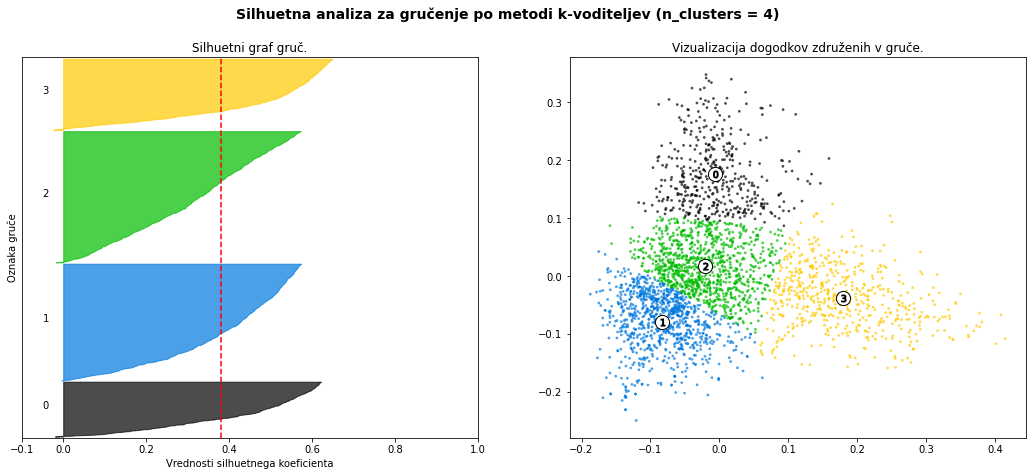





Cluster 1: oder, večer, skupina, nov, slovenski, glasben, let, vstopnica, glasba, koncert
Cluster 2: del, pot, vabiti, več, otrok, življenje, predavanje, delavnica, lahek, prijava
Cluster 3: rocka, pesem, slovenski, kitara, glasba, skupina, glasben, let, album, koncert
Cluster 4: letos, mesto, dober, lahek, dan, vstopnica, dogodek, sobota, ura, vabiti
Cluster 5: dogodek, vstopnina, vip, infa, klub, miza, vstopnica, rezervacija, zabava, dje


For n_clusters = 5 The average silhouette_score is : 0.36399055995619056



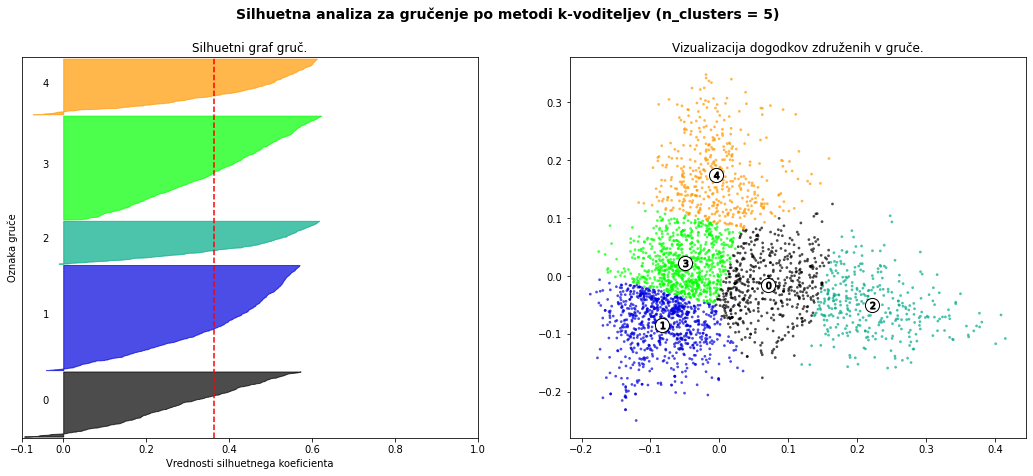





Cluster 1: tekmovanje, dan, mesto, prijava, ekipa, sobota, dogodek, lahek, ura, vabiti
Cluster 2: rocka, pesem, slovenski, kitara, glasba, skupina, glasben, let, album, koncert
Cluster 3: dogodek, vstopnina, vstopnica, infa, klub, vip, zabava, miza, rezervacija, dje
Cluster 4: dober, ura, dan, vabiti, sobota, dogodek, vstopnina, zabava, dje, vstopnica
Cluster 5: pot, del, film, več, otrok, prijava, lahek, življenje, delavnica, predavanje
Cluster 6: skupina, večer, predstava, nov, slovenski, glasben, vstopnica, glasba, let, koncert


For n_clusters = 6 The average silhouette_score is : 0.3429839742686974



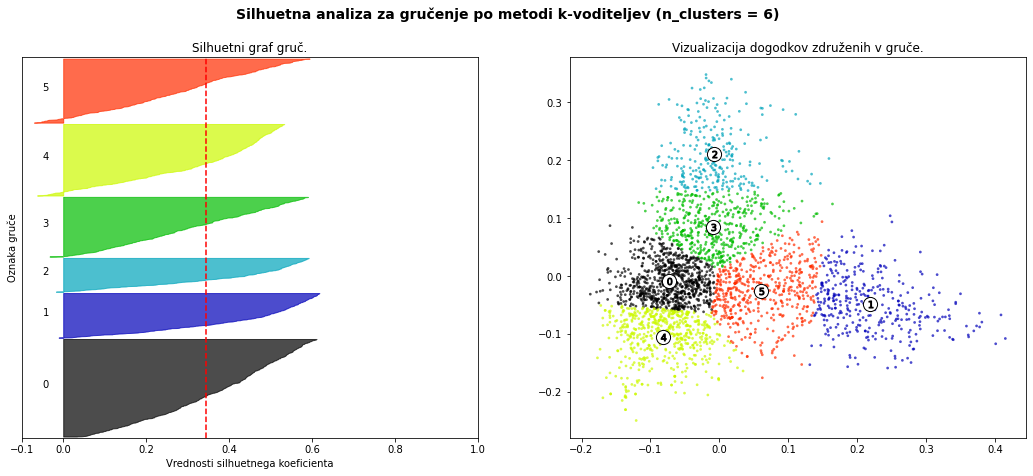





Cluster 1: tekmovanje, tek, dan, prijava, dogodek, ekipa, lahek, sobota, ura, vabiti
Cluster 2: vokati, rocka, slovenski, glasba, kitara, skupina, let, koncert, glasben, album
Cluster 3: odnos, pot, del, več, otrok, lahek, prijava, delavnica, življenje, predavanje
Cluster 4: mesto, ljubljana, koncert, film, več, vstopnica, nov, slovenski, let, predstava
Cluster 5: zasedba, nov, slovenski, album, skupina, vstopnica, let, glasben, glasba, koncert
Cluster 6: dober, ura, dan, vabiti, sobota, dogodek, zabava, vstopnina, dje, vstopnica
Cluster 7: dogodek, vstopnina, vstopnica, infa, klub, vip, zabava, miza, rezervacija, dje


For n_clusters = 7 The average silhouette_score is : 0.3442112446211922



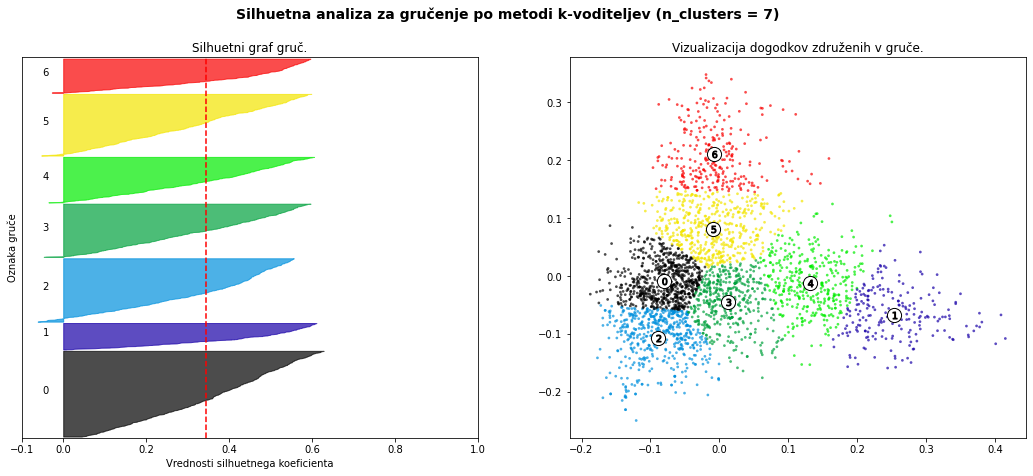





Cluster 1: letos, pijača, dober, vstopnica, dan, zabava, dogodek, ura, vabiti, sobota
Cluster 2: prijava, otrok, več, odnos, del, lahek, film, delavnica, predavanje, življenje
Cluster 3: zasedba, nov, slovenski, album, vstopnica, skupina, let, glasben, glasba, koncert
Cluster 4: dogodek, vstopnina, klub, vstopnica, infa, vip, miza, zabava, rezervacija, dje
Cluster 5: vokati, slovenski, rocka, glasba, skupina, kitara, let, glasben, koncert, album
Cluster 6: velik, ljubljana, mesto, koncert, več, nov, vstopnica, slovenski, let, predstava
Cluster 7: let, dogodek, večer, predprodaja, glasba, koncert, vstopnina, klub, dje, vstopnica
Cluster 8: pot, otrok, pohod, tek, dogodek, ekipa, ura, vabiti, lahek, prijava


For n_clusters = 8 The average silhouette_score is : 0.344501990554728



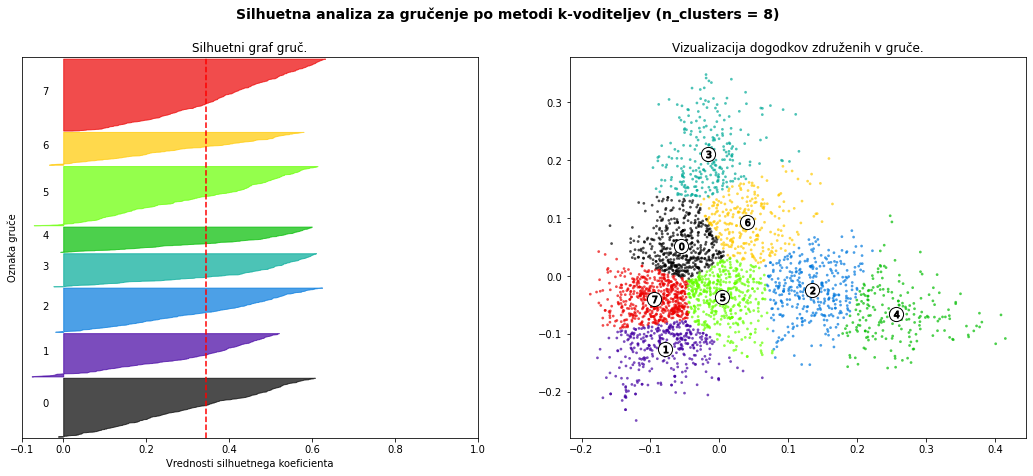





Cluster 1: mesto, tek, tekmovanje, sobota, dogodek, ekipa, lahek, prijava, ura, vabiti
Cluster 2: zasedba, nov, slovenski, vstopnica, album, skupina, let, glasben, glasba, koncert
Cluster 3: pot, znanje, več, odnos, življenje, lahek, otrok, prijava, delavnica, predavanje
Cluster 4: dogodek, vstopnina, vstopnica, klub, infa, vip, zabava, miza, rezervacija, dje
Cluster 5: poskrbeti, dober, dan, pijača, dogodek, vstopnica, vabiti, sobota, ura, zabava
Cluster 6: mesto, vabiti, dogodek, slovenski, let, večer, nov, koncert, predstava, vstopnica
Cluster 7: hous, dogodek, infa, predprodaja, glasba, vstopnina, koncert, klub, dje, vstopnica
Cluster 8: predstava, razstava, del, slovenski, zgodba, več, življenje, svet, let, film
Cluster 9: zasedba, slovenski, rocka, glasba, skupina, kitara, glasben, let, koncert, album


For n_clusters = 9 The average silhouette_score is : 0.34306002394109436



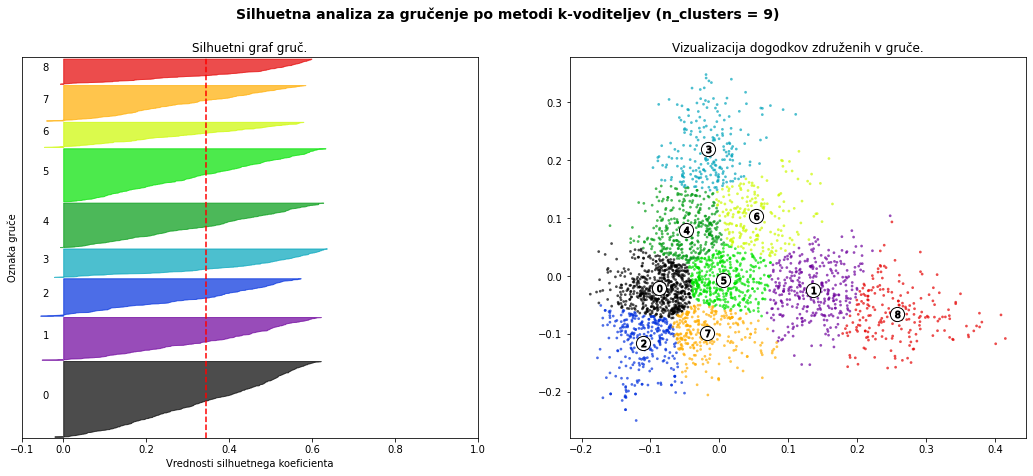





Cluster 1: rocka, pesem, slovenski, kitara, skupina, album, glasba, glasben, let, koncert
Cluster 2: prost, lahek, dober, letos, dan, vstopnica, dogodek, ura, sobota, vabiti
Cluster 3: delavnica, dogodek, otrok, pohod, tek, ekipa, ura, vabiti, lahek, prijava
Cluster 4: let, predprodaja, velik, glasba, koncert, infa, vstopnina, klub, dje, vstopnica
Cluster 5: ljubljana, zgodba, mesto, vstopnica, več, nov, film, slovenski, let, predstava
Cluster 6: film, več, del, otrok, prijava, odnos, lahek, delavnica, življenje, predavanje
Cluster 7: vokati, nov, zasedba, glasba, kitara, koncert, glasben, skupina, let, album
Cluster 8: pijača, ura, sobota, žura, vstopnica, rezervacija, vstopnina, dogodek, dje, zabava
Cluster 9: zasedba, slovenski, nov, let, večer, skupina, glasben, vstopnica, glasba, koncert
Cluster 10: klub, vstop, vstopnica, infa, boati, zabava, dje, rezervacija, vip, miza


For n_clusters = 10 The average silhouette_score is : 0.32398563159340843



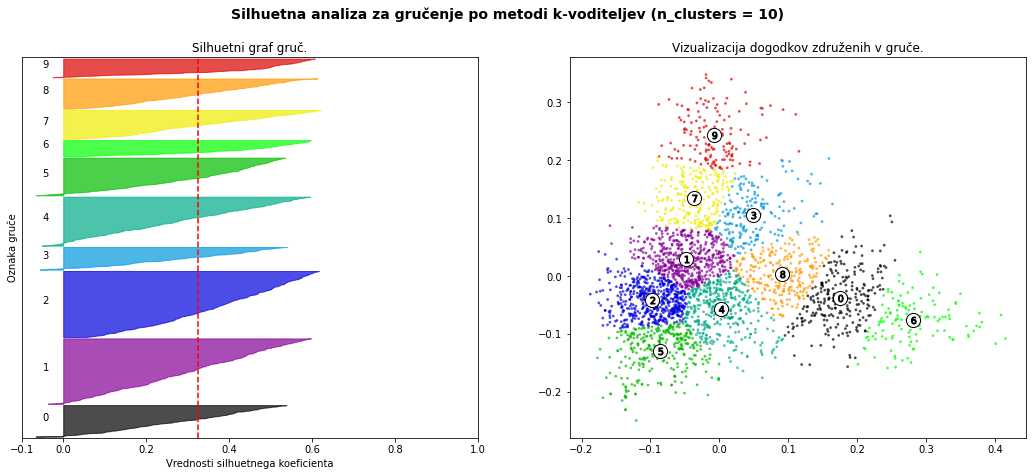





Cluster 1: pijača, lahek, vino, dober, letos, pusten, dogodek, sobota, ura, vabiti
Cluster 2: slovenski, rocka, zasedba, glasba, kitara, skupina, koncert, glasben, let, album
Cluster 3: prijava, več, otrok, del, odnos, lahek, film, delavnica, življenje, predavanje
Cluster 4: nov, slovenski, kitara, vstopnica, album, skupina, glasba, let, glasben, koncert
Cluster 5: dogodek, klub, vstopnica, infa, boati, zabava, vip, rezervacija, dje, miza
Cluster 6: nov, let, glasba, vabiti, vstopnina, skupina, dogodek, večer, vstopnica, koncert
Cluster 7: nov, komedij, ljubljana, več, glasba, koncert, glasben, slovenski, predstava, let
Cluster 8: predprodaja, dogodek, let, hous, glasba, vstopnina, infa, klub, vstopnica, dje
Cluster 9: tekmovanje, vabiti, otrok, ura, delavnica, ekipa, tek, lahek, pohod, prijava
Cluster 10: film, maribor, več, vabiti, lahek, velik, predstava, nov, slovenski, mesto
Cluster 11: dan, ura, dogodek, pijača, vstopnina, trnovfesti, sobota, vstopnica, dje, zabava


For n_cl

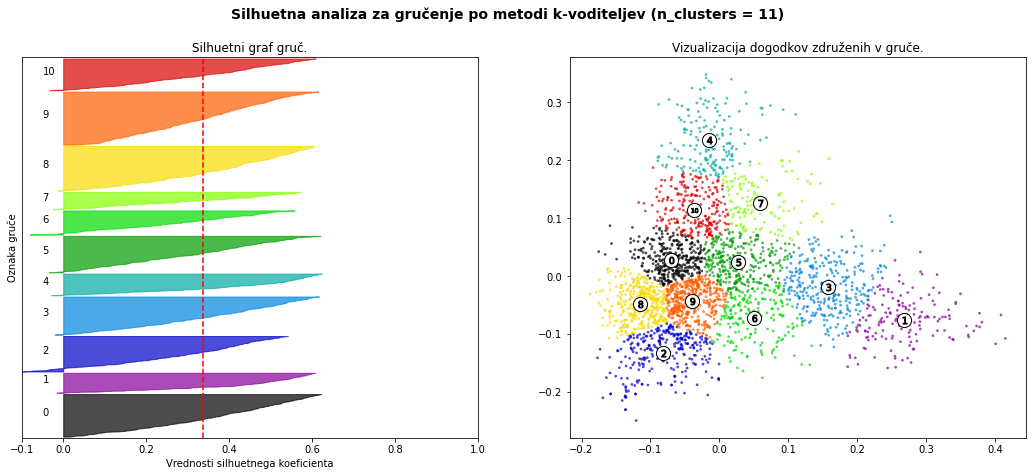





Cluster 1: klub, vstop, infa, boati, vstopnica, dje, zabava, rezervacija, vip, miza
Cluster 2: večer, dogodek, slovenski, let, vabiti, velik, mesto, predstava, nov, vstopnica
Cluster 3: nov, slovenski, pesem, kitara, skupina, glasba, album, glasben, let, koncert
Cluster 4: čustvo, znanje, telo, lahek, odnos, prijava, otrok, življenje, delavnica, predavanje
Cluster 5: poskrbeti, pijača, pusten, dober, letos, zabava, dogodek, ura, sobota, vabiti
Cluster 6: glasba, večer, predprodaja, dogodek, dan, klub, vstopnina, trnovfesti, dje, vstopnica
Cluster 7: maribor, let, več, nov, del, knjiga, svet, razstava, življenje, film
Cluster 8: pijača, dogodek, žura, infa, sobota, klub, rezervacija, vstopnina, zabava, dje
Cluster 9: večer, slovenski, nov, album, skupina, let, glasben, glasba, vstopnica, koncert
Cluster 10: dogodek, pot, otrok, tek, pohod, ekipa, ura, vabiti, lahek, prijava
Cluster 11: ljubljana, svet, komedij, glasba, več, koncert, glasben, slovenski, predstava, let
Cluster 12: roc

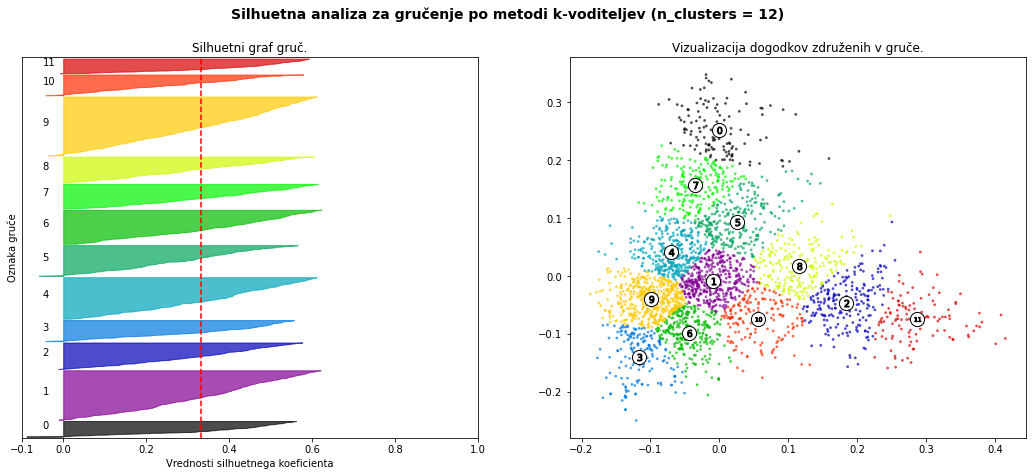

In [5]:
print('----------------------- PCA dimensionality reduction ----------------------')
# We train the PCA on the dense version of the tf-idf. 
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_idf.todense())

silhouette_score_and_graphs(X_pca, 4, 12, False)

----------------------- PCA dimensionality reduction ----------------------
Cluster 1: pot, del, več, film, otrok, lahek, prijava, življenje, delavnica, predavanje
Cluster 2: rocka, pesem, slovenski, kitara, glasba, skupina, glasben, let, album, koncert
Cluster 3: tekmovanje, dan, mesto, prijava, ekipa, sobota, dogodek, lahek, ura, vabiti
Cluster 4: dober, ura, dan, vabiti, sobota, dogodek, vstopnina, zabava, dje, vstopnica
Cluster 5: skupina, večer, predstava, nov, slovenski, glasben, vstopnica, glasba, let, koncert
Cluster 6: dogodek, vstopnina, vstopnica, infa, klub, vip, zabava, miza, rezervacija, dje


For n_clusters = 6 The average silhouette_score is : 0.34275576127338114



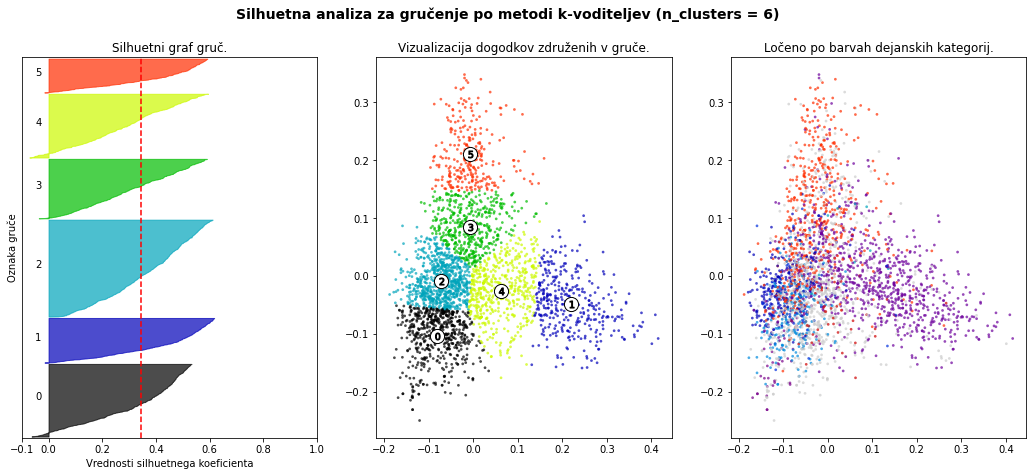





Cluster 1: pot, odnos, del, več, otrok, prijava, lahek, delavnica, življenje, predavanje
Cluster 2: dober, ura, dan, vabiti, sobota, zabava, vstopnina, dogodek, dje, vstopnica
Cluster 3: vokati, rocka, slovenski, glasba, kitara, skupina, let, glasben, koncert, album
Cluster 4: mesto, ljubljana, koncert, več, film, vstopnica, nov, slovenski, let, predstava
Cluster 5: dogodek, vstopnina, vstopnica, infa, klub, vip, zabava, miza, rezervacija, dje
Cluster 6: dan, mesto, tekmovanje, dogodek, prijava, sobota, ekipa, lahek, ura, vabiti
Cluster 7: zasedba, nov, slovenski, album, skupina, vstopnica, let, glasben, glasba, koncert


For n_clusters = 7 The average silhouette_score is : 0.3457859308428493



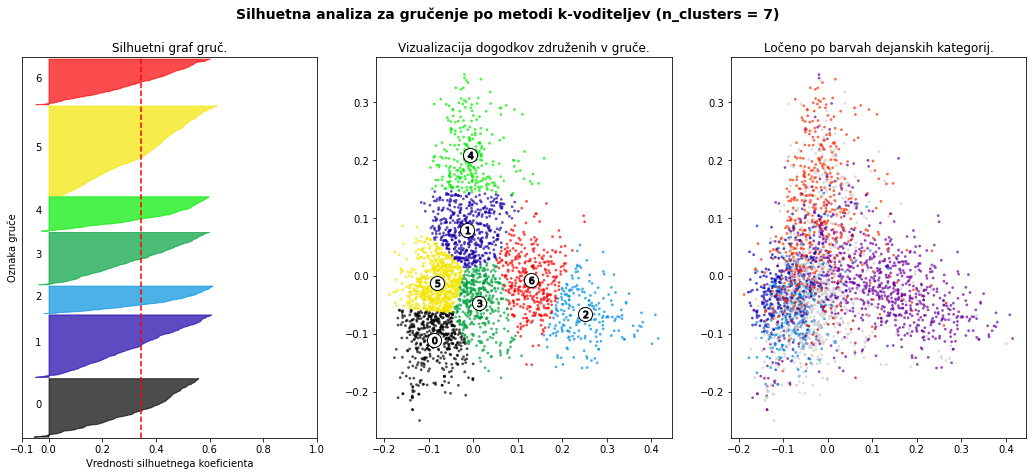





Cluster 1: komedij, mesto, ljubljana, več, koncert, nov, vstopnica, slovenski, let, predstava
Cluster 2: dogodek, vstopnina, klub, vstopnica, infa, vip, miza, zabava, rezervacija, dje
Cluster 3: zasedba, slovenski, rocka, glasba, skupina, kitara, glasben, let, koncert, album
Cluster 4: tek, tekmovanje, otrok, mesto, dogodek, ekipa, ura, lahek, vabiti, prijava
Cluster 5: odnos, del, več, prijava, otrok, film, lahek, delavnica, življenje, predavanje
Cluster 6: glasben, hous, dogodek, predprodaja, glasba, vstopnina, koncert, klub, dje, vstopnica
Cluster 7: zasedba, nov, slovenski, vstopnica, album, skupina, let, glasben, glasba, koncert
Cluster 8: pijača, poskrbeti, dober, dan, vstopnica, dogodek, zabava, ura, sobota, vabiti


For n_clusters = 8 The average silhouette_score is : 0.34424514174842735



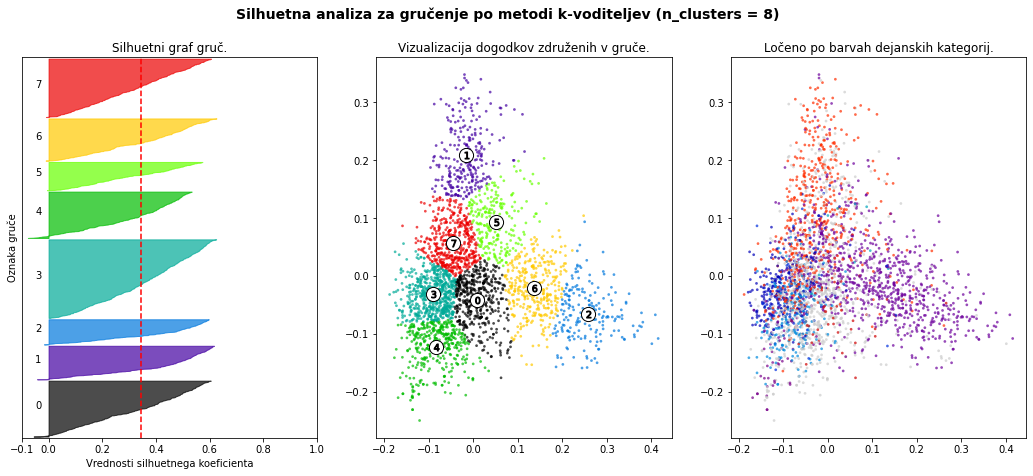





Cluster 1: otrok, pot, dogodek, ekipa, tek, pohod, ura, vabiti, lahek, prijava
Cluster 2: zgodba, ljubljana, koncert, vstopnica, več, nov, film, slovenski, predstava, let
Cluster 3: dan, vabiti, dogodek, pijača, vstopnina, trnovfesti, sobota, dje, vstopnica, zabava
Cluster 4: pesem, nov, slovenski, vstopnica, album, skupina, glasba, let, glasben, koncert
Cluster 5: let, predprodaja, klub, dogodek, vstopnina, večer, glasba, dje, koncert, vstopnica
Cluster 6: prijava, več, otrok, film, odnos, del, lahek, delavnica, življenje, predavanje
Cluster 7: zasedba, slovenski, rocka, glasba, skupina, kitara, koncert, glasben, let, album
Cluster 8: mesto, nov, dober, lahek, dan, letos, dogodek, sobota, ura, vabiti
Cluster 9: dan, dogodek, klub, vstopnica, infa, zabava, vip, miza, dje, rezervacija


For n_clusters = 9 The average silhouette_score is : 0.33044511994523884



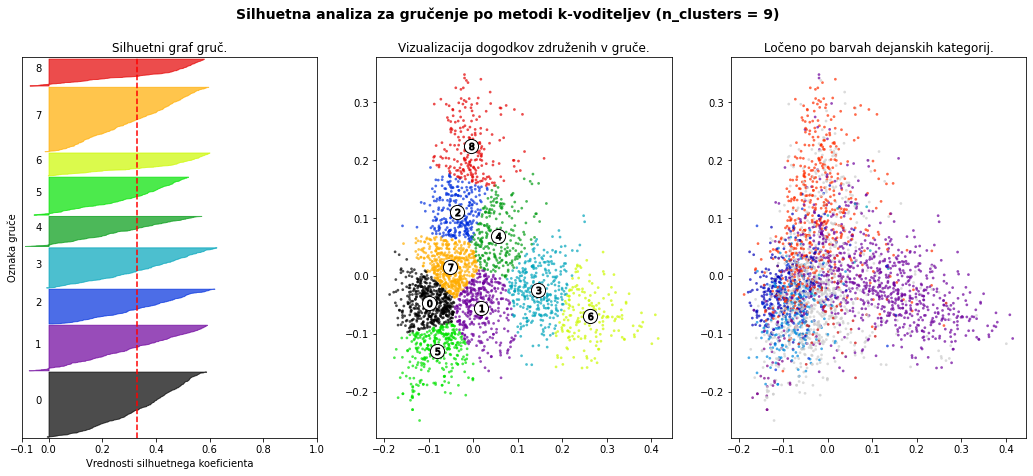





Cluster 1: let, predprodaja, klub, dogodek, večer, vstopnina, glasba, dje, koncert, vstopnica
Cluster 2: delavnica, dogodek, otrok, tek, ekipa, pohod, vabiti, ura, lahek, prijava
Cluster 3: vstopnina, dogodek, vstopnica, klub, infa, zabava, vip, miza, rezervacija, dje
Cluster 4: slovenski, nov, zasedba, kitara, glasba, skupina, koncert, glasben, let, album
Cluster 5: zgodba, ljubljana, mesto, več, vstopnica, film, nov, slovenski, let, predstava
Cluster 6: prijava, več, otrok, film, del, odnos, lahek, delavnica, predavanje, življenje
Cluster 7: dober, nov, dan, lahek, tekma, letos, dogodek, sobota, ura, vabiti
Cluster 8: svet, zasedba, nov, skupina, glasbenik, slovenski, let, glasba, glasben, koncert
Cluster 9: pijača, dan, dogodek, vabiti, vstopnina, trnovfesti, dje, sobota, vstopnica, zabava
Cluster 10: slovenski, rocka, kitara, glasba, album, vstopnica, skupina, glasben, let, koncert


For n_clusters = 10 The average silhouette_score is : 0.32135177748547994



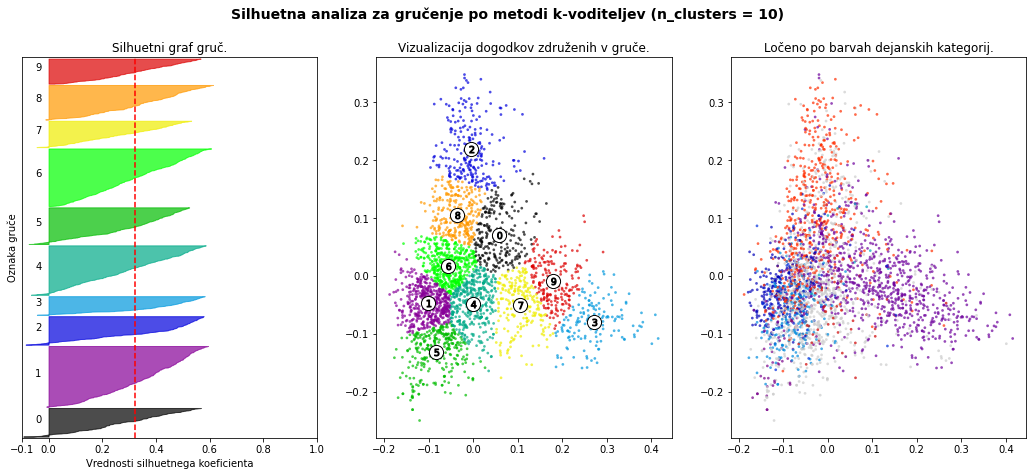





Cluster 1: glasba, ljubljana, film, glasben, nov, komedij, več, slovenski, predstava, let
Cluster 2: let, hous, predprodaja, glasba, infa, dogodek, vstopnina, klub, vstopnica, dje
Cluster 3: vstopnica, slovenski, pesem, kitara, skupina, glasba, album, glasben, let, koncert
Cluster 4: sobota, lahek, letos, mesto, nov, dan, vstopnica, ura, dogodek, vabiti
Cluster 5: delavnica, pot, vabiti, tekmovanje, tek, pohod, lahek, ura, ekipa, prijava
Cluster 6: dogodek, boati, klub, vstopnica, infa, vip, zabava, miza, rezervacija, dje
Cluster 7: vabiti, slovenski, nov, skupina, let, večer, glasben, glasba, vstopnica, koncert
Cluster 8: dan, dogodek, poskrbeti, trnovfesti, vstopnica, pijača, ura, vabiti, sobota, zabava
Cluster 9: nov, predavanje, lahek, knjiga, del, več, življenje, svet, razstava, film
Cluster 10: čustvo, znanje, telo, lahek, prijava, otrok, odnos, delavnica, življenje, predavanje
Cluster 11: nov, vokati, zasedba, kitara, glasba, koncert, skupina, glasben, let, album


For n_clu

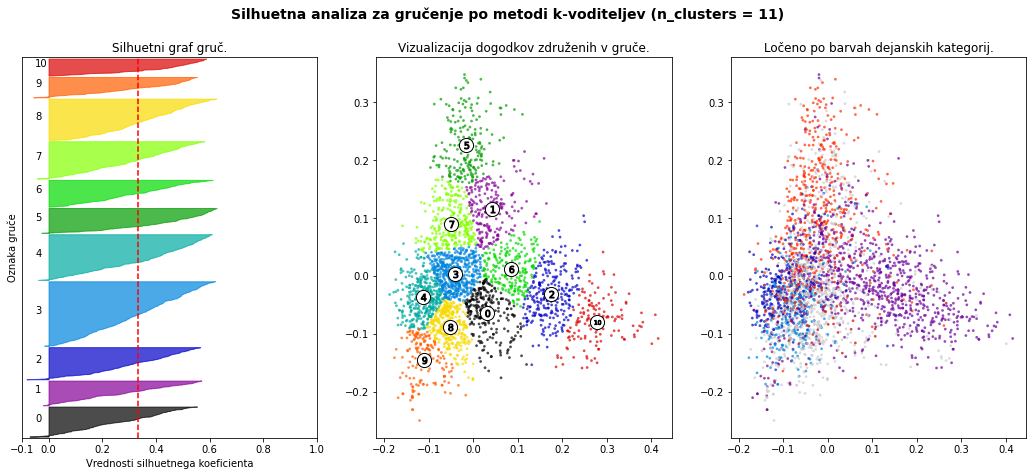

In [6]:
print('----------------------- PCA dimensionality reduction ----------------------')
# We train the PCA on the dense version of the tf-idf. 
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_idf.todense())

silhouette_score_and_graphs(X_pca, 6, 11, True)

----------------------- TSNE dimensionality reduction perplexity=100 ----------------------
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 2953 samples in 0.008s...
[t-SNE] Computed neighbors for 2953 samples in 0.471s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2953
[t-SNE] Computed conditional probabilities for sample 2000 / 2953
[t-SNE] Computed conditional probabilities for sample 2953 / 2953
[t-SNE] Mean sigma: 0.342106
[t-SNE] KL divergence after 150 iterations with early exaggeration: 68.504982
[t-SNE] KL divergence after 4000 iterations: 1.769804
Cluster 1: svet, dogodek, več, tečaj, otrok, prijava, življenje, lahek, delavnica, predavanje
Cluster 2: vstopnica, nov, rocka, kitara, skupina, glasba, glasben, let, album, koncert
Cluster 3: vstopnina, vip, dan, miza, zabava, dogodek, klub, rezervacija, vstopnica, dje
Cluster 4: pot, vabiti, lahek, tekmovanje, prijava, pohod, ura, tek, ekipa, film
Cluster 5: dober, skupina, koncert, letos, zabava, pust

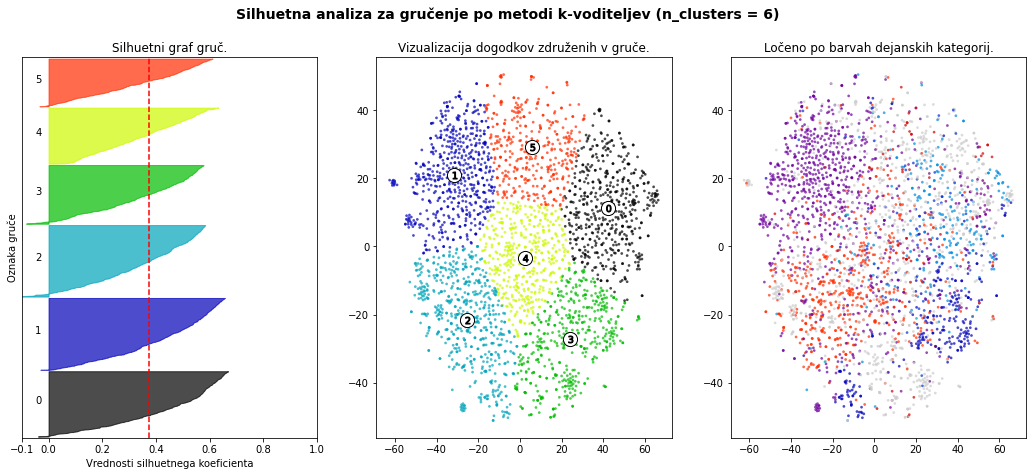





Cluster 1: vabiti, lahek, pot, ura, tekmovanje, prijava, pohod, tek, ekipa, film
Cluster 2: nov, slovenski, rocka, kitara, skupina, glasba, let, album, glasben, koncert
Cluster 3: skupina, dober, letos, koncert, ura, pusten, sobota, zabava, ansambel, vabiti
Cluster 4: dogodek, odnos, več, otrok, tečaj, prijava, lahek, življenje, delavnica, predavanje
Cluster 5: vabiti, predstava, slovenski, let, mesto, maribor, ljubljana, anda, plesen, razstava
Cluster 6: ura, trnovfesti, cena, žura, eura, tekma, predprodaja, dogodek, dan, vstopnica
Cluster 7: let, dogodek, zabava, vstopnina, rezervacija, miza, vip, infa, klub, dje


For n_clusters = 7 The average silhouette_score is : 0.37615374



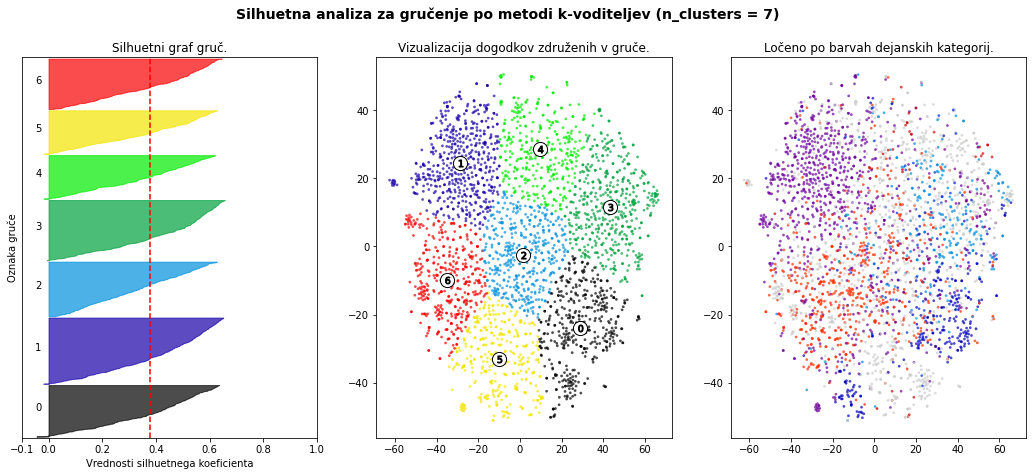





Cluster 1: vino, sobota, letos, prazničen, predstava, lahek, program, ura, sejem, vabiti
Cluster 2: predstava, let, slovenski, koncert, mesto, maribor, ljubljana, anda, plesen, razstava
Cluster 3: del, odnos, več, otrok, lahek, tečaj, prijava, delavnica, življenje, predavanje
Cluster 4: maska, dober, nor, sobota, skupina, vabiti, ansambel, pusten, koncert, zabava
Cluster 5: slovenski, nov, rocka, kitara, skupina, glasba, let, glasben, album, koncert
Cluster 6: hous, let, vstopnina, dogodek, rezervacija, vip, miza, klub, infa, dje
Cluster 7: vabiti, lahek, ura, pot, prijava, tekmovanje, pohod, tek, ekipa, film
Cluster 8: cena, sobota, eura, žura, ura, predprodaja, tekma, dogodek, dan, vstopnica


For n_clusters = 8 The average silhouette_score is : 0.36642668



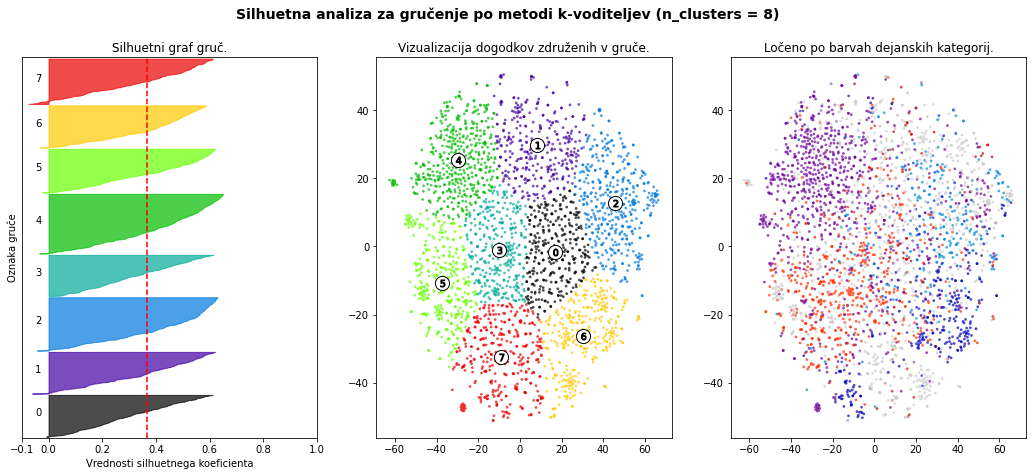





Cluster 1: rezervacija, cena, žura, trnovfesti, eura, dogodek, predprodaja, tekma, dan, vstopnica
Cluster 2: bend, nov, glasba, rocka, glasben, kitara, skupina, let, koncert, album
Cluster 3: prostor, vabiti, dogodek, vino, ljubljana, svet, lahek, mesto, maribor, razstava
Cluster 4: vstopnica, orkester, glasbenik, pesem, anda, plesen, slovenski, glasba, glasben, koncert
Cluster 5: znanje, več, odnos, lahek, otrok, prijava, tečaj, življenje, delavnica, predavanje
Cluster 6: hous, dogodek, vstopnina, zabava, rezervacija, miza, infa, vip, klub, dje
Cluster 7: maska, letos, skupina, koncert, ura, pusten, sobota, zabava, ansambel, vabiti
Cluster 8: igralec, dober, ura, pivo, turnir, komedij, vstopnica, burger, ekipa, film
Cluster 9: trasa, vabiti, sejem, lahek, ura, pot, tekmovanje, prijava, tek, pohod


For n_clusters = 9 The average silhouette_score is : 0.3492578



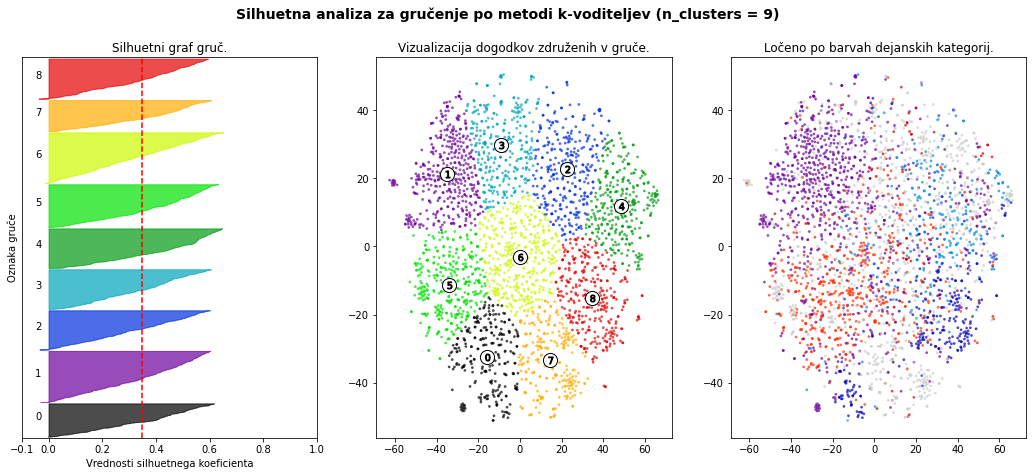





Cluster 1: vstopnica, orkester, glasbenik, pesem, anda, slovenski, plesen, glasba, koncert, glasben
Cluster 2: cena, karta, rezervacija, trnovfesti, eura, dogodek, predprodaja, tekma, dan, vstopnica
Cluster 3: letos, otrok, ura, sejem, lahek, program, predstava, prazničen, vino, vabiti
Cluster 4: bend, nov, glasba, rocka, glasben, kitara, skupina, koncert, let, album
Cluster 5: noč, dober, nor, skupina, pusten, sobota, vabiti, koncert, ansambel, zabava
Cluster 6: vabiti, lahek, dirka, trasa, ura, pot, tekmovanje, prijava, tek, pohod
Cluster 7: zabava, dogodek, hous, vstopnina, rezervacija, infa, miza, vip, klub, dje
Cluster 8: več, znanje, odnos, lahek, otrok, prijava, tečaj, življenje, delavnica, predavanje
Cluster 9: dober, dogodek, pivo, turnir, komedij, vstopnica, ura, burger, ekipa, film
Cluster 10: ljubljana, let, umetnost, fotografija, več, svet, mesto, knjiga, maribor, razstava


For n_clusters = 10 The average silhouette_score is : 0.35537553



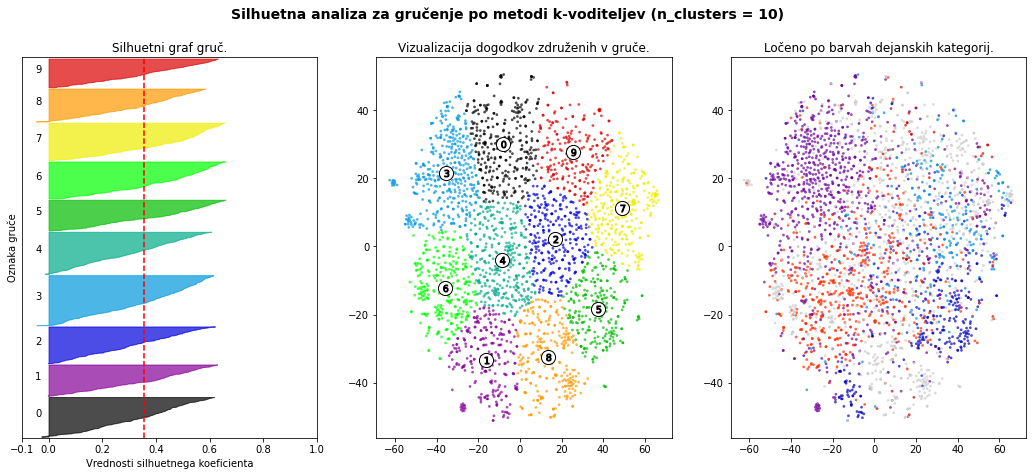





Cluster 1: vstopnina, dober, nor, skupina, pusten, sobota, koncert, vabiti, ansambel, zabava
Cluster 2: galerija, delavnica, prostor, let, maribor, fotografija, več, svet, knjiga, razstava
Cluster 3: vokati, slovenski, album, pesem, let, skupina, kitara, glasba, koncert, glasben
Cluster 4: ekipa, lahek, dirka, trasa, ura, pot, tekmovanje, prijava, tek, pohod
Cluster 5: žura, rezervacija, karta, eura, trnovfesti, dogodek, predprodaja, tekma, dan, vstopnica
Cluster 6: dober, dogodek, pivo, turnir, komedij, vstopnica, ura, burger, ekipa, film
Cluster 7: zbor, glasben, slovenski, ples, predstava, ljubljana, glasba, koncert, anda, plesen
Cluster 8: techen, dogodek, hous, vstopnina, rezervacija, infa, vip, miza, klub, dje
Cluster 9: čustvo, znanje, odnos, lahek, otrok, prijava, delavnica, življenje, tečaj, predavanje
Cluster 10: dogodek, letos, ura, sejem, lahek, predstava, prazničen, program, vino, vabiti
Cluster 11: kti, vstopnica, nov, skupina, bend, rocka, koncert, metati, let, album

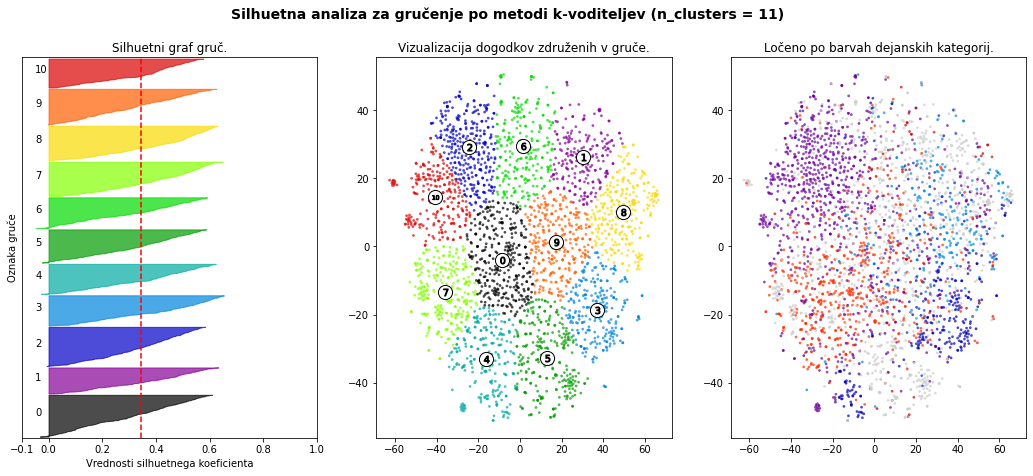

In [7]:
print('----------------------- TSNE dimensionality reduction perplexity=100 ----------------------')


tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=4000, learning_rate=200)
X_tsne = tsne.fit_transform(X_idf.todense())
silhouette_score_and_graphs(X_tsne, 6, 11, True)

----------------------- TSNE dimensionality reduction perplexity=30 ----------------------
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2953 samples in 0.008s...
[t-SNE] Computed neighbors for 2953 samples in 1.151s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2953
[t-SNE] Computed conditional probabilities for sample 2000 / 2953
[t-SNE] Computed conditional probabilities for sample 2953 / 2953
[t-SNE] Mean sigma: 0.322903
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.791153
[t-SNE] KL divergence after 4000 iterations: 1.870926
Cluster 1: pesem, zasedba, predstava, slovenski, let, skupina, kitara, glasba, glasben, koncert
Cluster 2: sobota, nov, dogodek, dan, vabiti, koncert, ura, tekma, mesto, vstopnica
Cluster 3: glasba, dogodek, dje, anda, nov, skupina, vstopnica, koncert, album, let
Cluster 4: ljubljana, tečaj, otrok, več, prijava, delavnica, lahek, film, življenje, predavanje
Cluster 5: vstop, klub, vstopnina, vstopnica, sob

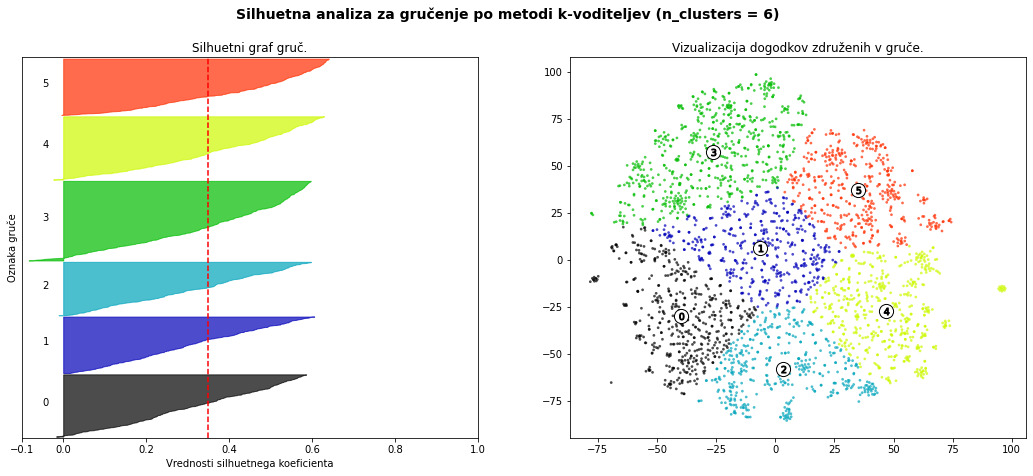





Cluster 1: pot, pusten, sobota, tekmovanje, pohod, prijava, vabiti, tek, ekipa, ura
Cluster 2: vstopnica, nov, rocka, glasben, glasba, kitara, skupina, let, album, koncert
Cluster 3: glasbenik, let, plesen, pesem, vstopnica, slovenski, glasba, predstava, koncert, glasben
Cluster 4: vstop, dogodek, vip, infa, vstopnina, miza, klub, rezervacija, zabava, dje
Cluster 5: odnos, dogodek, več, življenje, lahek, otrok, tečaj, prijava, predavanje, delavnica
Cluster 6: prazničen, dan, mesto, ansambel, ura, sobota, koncert, tekma, vabiti, vstopnica
Cluster 7: svet, ljubljana, zgodba, več, maribor, mesto, let, življenje, razstava, film


For n_clusters = 7 The average silhouette_score is : 0.3650179



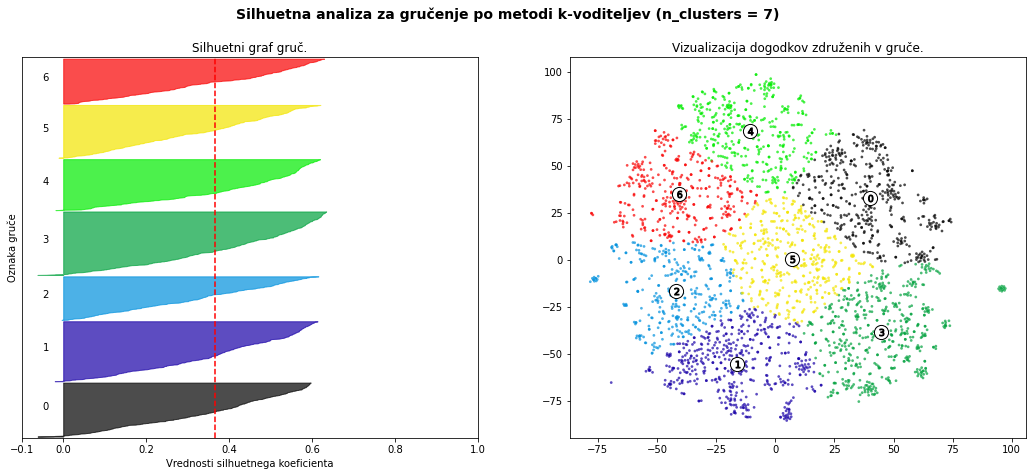





Cluster 1: zasedba, rocka, pesem, kitara, glasba, glasben, skupina, let, album, koncert
Cluster 2: dogodek, odnos, več, življenje, lahek, otrok, tečaj, prijava, predavanje, delavnica
Cluster 3: prazničen, dan, mesto, ura, ansambel, koncert, vabiti, sobota, tekma, vstopnica
Cluster 4: nov, glasba, glasben, koncert, komedij, let, plesen, slovenski, vstopnica, predstava
Cluster 5: vstop, klub, nor, pusten, sobota, dje, vip, miza, zabava, rezervacija
Cluster 6: hous, techen, glasba, let, infa, vstopnina, klub, dogodek, anda, dje
Cluster 7: lahek, pot, sobota, prijava, tekmovanje, pohod, vabiti, tek, ekipa, ura
Cluster 8: let, zgodba, svet, mesto, ljubljana, knjiga, maribor, življenje, razstava, film


For n_clusters = 8 The average silhouette_score is : 0.35882893



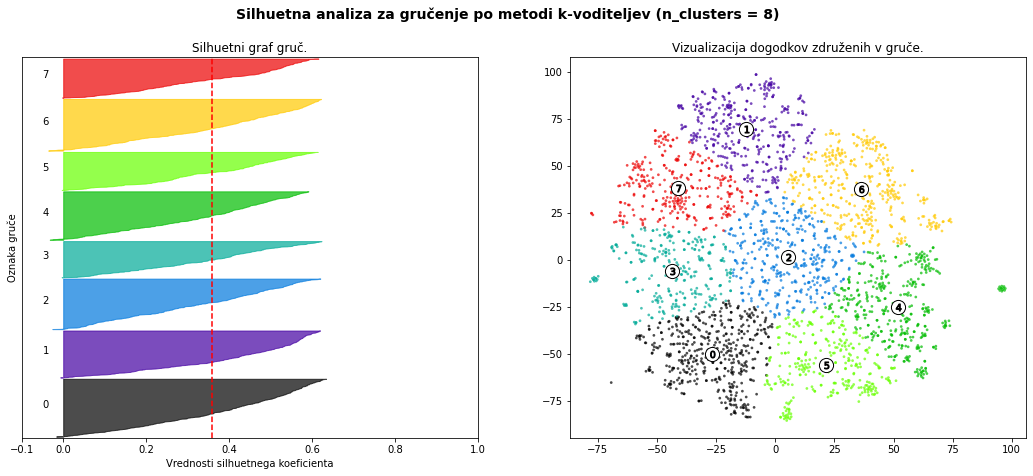





Cluster 1: gasilski, dober, burger, nagrada, maska, ura, sobota, vabiti, ekipa, pusten
Cluster 2: dogodek, predprodaja, ansambel, dan, prazničen, ura, vabiti, tekma, koncert, vstopnica
Cluster 3: znanje, več, odnos, življenje, lahek, otrok, prijava, tečaj, predavanje, delavnica
Cluster 4: vstopnica, party, sobota, nor, vstop, dje, vip, miza, zabava, rezervacija
Cluster 5: smeh, glasba, glasben, koncert, let, komedij, plesen, slovenski, vstopnica, predstava
Cluster 6: vino, tekmovanje, vabiti, sejem, lahek, ura, pot, prijava, pohod, tek
Cluster 7: nov, pesem, rocka, kitara, glasba, glasben, skupina, let, album, koncert
Cluster 8: glasba, hous, let, infa, techen, vstopnina, dogodek, klub, anda, dje
Cluster 9: let, lahek, knjiga, ljubljana, svet, mesto, maribor, življenje, razstava, film


For n_clusters = 9 The average silhouette_score is : 0.35554907



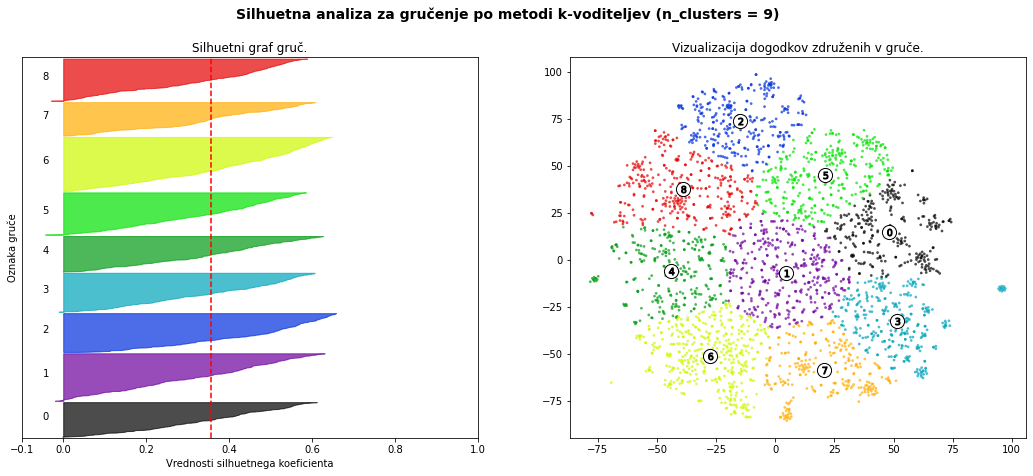





Cluster 1: več, večer, mesto, smeh, slovenski, let, vstopnica, plesen, komedij, predstava
Cluster 2: aga, infa, vstopnina, glasba, hous, techen, dogodek, klub, anda, dje
Cluster 3: znanje, več, odnos, življenje, lahek, otrok, prijava, predavanje, tečaj, delavnica
Cluster 4: turnir, gasilski, nagrada, maska, burger, ura, vabiti, sobota, ekipa, pusten
Cluster 5: glasben, vstopnica, bend, nov, metati, rocka, skupina, let, koncert, album
Cluster 6: dan, vstopnina, vstop, nor, sobota, dje, vip, miza, zabava, rezervacija
Cluster 7: let, mesto, lahek, ljubljana, knjiga, svet, maribor, življenje, razstava, film
Cluster 8: trasa, tekmovanje, vabiti, lahek, sejem, ura, prijava, pot, pohod, tek
Cluster 9: sobota, mesto, dan, ansambel, prazničen, ura, vabiti, tekma, koncert, vstopnica
Cluster 10: glasbenik, zasedba, slovenski, let, pesem, skupina, kitara, glasba, glasben, koncert


For n_clusters = 10 The average silhouette_score is : 0.33742744



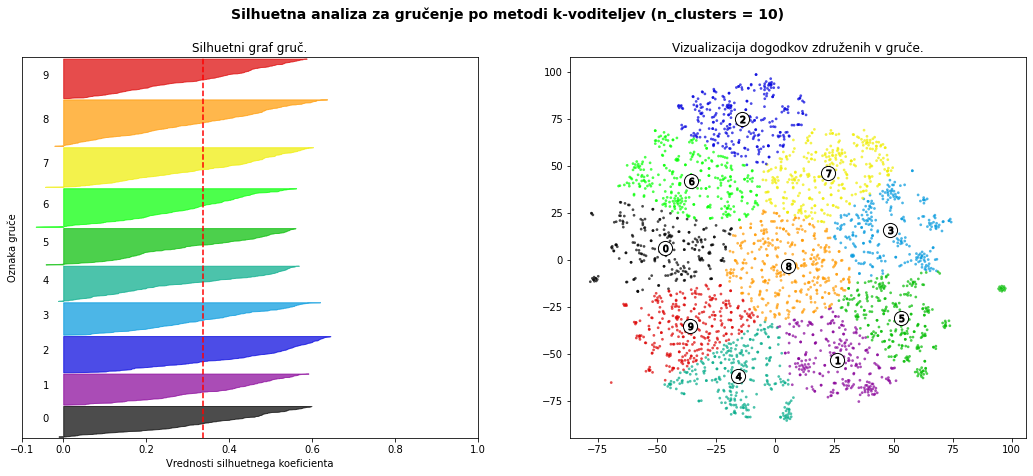





Cluster 1: zabava, veselica, pijača, ansambel, nov, letos, ura, vabiti, sobota, tekma
Cluster 2: will, kti, vstopnica, bend, nov, koncert, metati, anda, let, album
Cluster 3: znanje, več, odnos, življenje, lahek, otrok, prijava, tečaj, predavanje, delavnica
Cluster 4: hous, dogodek, vstopnina, zabava, vip, infa, miza, klub, rezervacija, dje
Cluster 5: vokati, slovenski, pesem, album, skupina, let, koncert, kitara, glasba, glasben
Cluster 6: več, fotografija, filmski, let, zgodba, ljubljana, knjiga, življenje, razstava, film
Cluster 7: prijavnina, turnir, lahek, ura, pot, tekmovanje, prijava, ekipa, pohod, tek
Cluster 8: nov, večer, koncert, smeh, let, slovenski, vstopnica, plesen, komedij, predstava
Cluster 9: ptovati, dan, party, sobota, burger, nor, zabava, trnovfesti, maska, pusten
Cluster 10: dan, društvo, vino, vabiti, mesto, lahek, program, prazničen, maribor, sejem
Cluster 11: dogodek, vabiti, žura, dan, razprodan, ansambel, predprodaja, skupina, vstopnica, koncert


For n_c

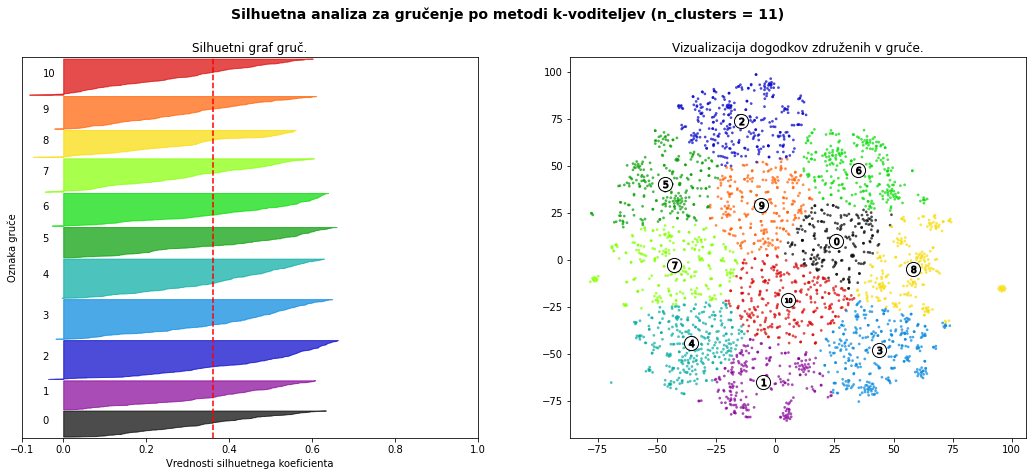

In [11]:
print('----------------------- TSNE dimensionality reduction perplexity=30 ----------------------')


tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=4000, learning_rate=200)
X_tsne = tsne.fit_transform(X_idf.todense())
silhouette_score_and_graphs(X_tsne, 6, 11, False)

In [12]:

# for i in range(100):
#     iPerplexity = random.randint(5,50)
#     iLearning_rate = random.randint(10,1000)
#     print('--------------------perplexiti=' + str(iPerplexity) + ', learning_rate=' + str(iLearning_rate) + ' -----------------------')
#     tsne = TSNE(n_components=2, verbose=0, perplexity=iPerplexity, n_iter=1000, learning_rate=iLearning_rate)
#     X_tsne = tsne.fit_transform(X_idf.todense())
#     silhouette_score_and_graphs(X_tsne, 7, 7)



In [13]:

# for i in range(50):
#     iPerplexity = random.randint(5,50)
#     iLearning_rate = random.randint(10,1000)
#     iEarly_exaggeration = random.randint(3,30)
#     print('--------------------perplexiti=' + str(iPerplexity) + ', learning_rate=' + str(iLearning_rate) + ' -----------------------')
#     tsne = TSNE(n_components=2, verbose=0, perplexity=iPerplexity, n_iter=1000, learning_rate=iLearning_rate, early_exaggeration=iEarly_exaggeration)
#     X_tsne = tsne.fit_transform(X_idf.todense())
#     silhouette_score_and_graphs(X_tsne, 7, 7)

